# import packages and load data

In [1]:
import rmsp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

import sys
sys.path.append('../python_modules/')  # Defining the path to my modules
from hyperparameter_tunning import RandomSearch_KF, GridSearch_KF
from conditional_distributions import ConditionalMG, ConditionalML
from evaluation import AccuracyEvaluator

---
# Load Data

In [2]:
# Loading data as we would with a "real" csv file
data = pd.read_csv('wl_semisyn_bivariate.csv')
# data_orig['z'] = 0

# Converting Pandas Dataframe into a RMSP Point Data
data = rmsp.PointData(data, x='x', y="y")
data.drop('x1_shift', axis=1, inplace=True)
data.rename(columns={'x1':'var1', 'tg':'var2'}, inplace=True)

type(data)

rmsp.core.point.PointData

# sub-sampling and splitting data

In [3]:
# Define threshold on the reference variable
thr_var = 'var1'
threshold = data[thr_var].quantile(0.50)

# fractions to select as "complete"
frac_above = 0.60
frac_below = 0.40

# Select samples above and below the median threshold
samples_above_threshold = data[data[thr_var] > threshold]
samples_below_threshold = data[(data[thr_var] < threshold)]

# Sample subsets
complete_set_above = samples_above_threshold.sample(frac=frac_above, random_state=42)
complete_set_below = samples_below_threshold.sample(frac=frac_below, random_state=42)

# Combine subsets
complete_set = pd.concat([complete_set_above, complete_set_below])

# Remaining samples (excluding complete set) go to missing set
missing_set = data.drop(complete_set.index)

# Split the "complete" subset into validation and modeling subsets
valid_set = complete_set.sample(frac=0.15, random_state=42)
model_set = complete_set.drop(valid_set.index)

# Create flags in the main dataframe
data['missing'] = 0
data['valid'] = 0
data['model'] = 0
data.loc[missing_set.index, 'missing'] = 1
data.loc[valid_set.index,   'valid']   = 1
data.loc[model_set.index,   'model']   = 1

In [4]:
# # Load in the data so the column of Primary can be retrieved
# df = pd.read_csv("synthetic_data_sampled.csv")
# df = rmsp.PointData(df, x='x', y="y")

# df['x1'] = df['var1']
# df.loc[df['missing'] == 0, 'tg'] = df['var2']

In [5]:
# df

In [6]:
# model_set = df[df['model'] == 1][['x', 'y', 'x1', 'tg']]
# valid_set = df[df['valid'] == 1][['x', 'y', 'x1', 'tg']]
# missing_set = df[df['missing'] == 1][['x', 'y', 'x1', 'var2']].rename(columns={'var2':'tg'})

# nscore

In [7]:
# Instantiate the transformers
# Each variable individually
despiker = rmsp.DespikeMVSpatial()
nscorer_x1 = rmsp.NSTransformer(warn_no_wt=False)
nscorer_tg = rmsp.NSTransformer(warn_no_wt=False)

In [8]:
# One variable at a time
data_dspk = despiker.fit_transform(model_set, variables=['var1', 'var2'])
data_dspk[['var1', 'var2']] = data_dspk.values

# Fit and transform predictors individually
nscorer_x1.fit(data_dspk['var1'], tail_values=[2.39, None])
model_set['NS_var1'] = nscorer_x1.transform(data_dspk['var1'])

# Fit and transform target individually
nscorer_tg.fit(data_dspk['var2'])
model_set['NS_var2'] = nscorer_tg.transform(data_dspk['var2'])

In [9]:
# Apply transformers and calculate nscores for hold out
# Each variable individually

# Despiking is also necessary!
data_dspk_valid = despiker.fit_transform(valid_set, ['var1', 'var2'])
data_dspk_valid[['var1', 'var2']] = data_dspk_valid.values

# Applying nscore individual transformers
valid_set['NS_var1'] = nscorer_x1.transform(data_dspk_valid['var1'])
valid_set['NS_var2'] = nscorer_tg.transform(data_dspk_valid['var2'])

In [10]:
valid_set

,x,y,var1,var2,NS_var1,NS_var2
702,1.0,260.0,4.289736,3.961207,-0.766793,-0.400745
55,10.0,20.0,4.348765,4.219794,-0.740533,0.259478
794,110.0,290.0,4.902181,4.406547,-0.320791,0.919127
137,20.0,50.0,5.098948,4.566788,-0.150380,1.678109
636,150.0,230.0,6.455208,3.294549,1.410893,-1.132899
...,...,...,...,...,...,...
4,40.0,1.0,4.753003,4.612557,-0.436318,1.942581
772,160.0,280.0,4.731833,4.132833,-0.463518,-0.039556
198,90.0,70.0,6.681858,2.789998,1.687485,-1.498127
309,120.0,110.0,4.602991,4.190194,-0.556082,0.149642


# calibrate R2

In [11]:
# Define quantile levels
n_quantiles = 500
quantile_levels = np.round(np.linspace(0.001, 0.999, n_quantiles), 3)

In [15]:
# Define the range for r_squared values
r2_test_avg = 0.6966
r2_train_avg = 0.7619
r2_kfolds_min = 0.5591
r2_kfolds_max = 0.7907

r_squared_values = np.linspace(r2_kfolds_min, r2_kfolds_max, 12)

# Prepare arrays to store results
tested_r_squared = np.zeros(len(r_squared_values))
goodness_metrics = np.zeros(len(r_squared_values))

# Iterate over each r_squared value
for i, r_squared in enumerate(r_squared_values):
    # Create SGB model instance
    model_ml = ConditionalML(
        regressor=GradientBoostingRegressor,
        r_squared=r_squared,
        reg_hyperparams={'alpha': 0.9,
                         'ccp_alpha': 0.0,
                         'criterion': 'friedman_mse',
                         'init': None,
                         'learning_rate': 0.05,
                         'loss': 'squared_error',
                         'max_depth': 2,
                         'max_features': None,
                         'max_leaf_nodes': None,
                         'min_impurity_decrease': 0.0,
                         'min_samples_leaf': 4,
                         'min_samples_split': 4,
                         'min_weight_fraction_leaf': 0.0,
                         'n_estimators': 100,
                         'n_iter_no_change': None,
                         'random_state': 42,
                         'subsample': 0.8,
                         'tol': 0.0001,
                         'validation_fraction': 0.1,
                         'verbose': 0,
                         'warm_start': False}
    )

    model_ml.fit(model_set[['NS_var1']].values, model_set['NS_var2'].values)

    # Predict validation/calibration set
    _, _, quantiles_ml, _, _ = model_ml.predict(valid_set['NS_var1'].values.reshape(-1,1), return_pdf=True)

    # Evaluate accuracy
    acc_ml = AccuracyEvaluator(quantile_levels, quantiles_ml, valid_set['NS_var2'].values)
    acc_ml_metrics = acc_ml.get_results()

    # Save r_squared and Goodness value
    tested_r_squared[i] = r_squared
    goodness_metrics[i] = acc_ml_metrics['Goodness']

In [16]:
# Final arrays with results
print("Tested r_squared values:", tested_r_squared.round(4))
print("Corresponding Goodness metrics:", goodness_metrics.round(4))

Tested r_squared values: [0.5591 0.5802 0.6012 0.6223 0.6433 0.6644 0.6854 0.7065 0.7275 0.7486
 0.7696 0.7907]
Corresponding Goodness metrics: [0.9202 0.9282 0.9353 0.944  0.9504 0.9583 0.9696 0.9709 0.9737 0.9648
 0.9529 0.9318]


In [17]:
# Find index of maximum Goodness
max_idx = np.argmax(goodness_metrics)

# Retrieve corresponding values
best_r_squared = tested_r_squared[max_idx]
best_goodness = goodness_metrics[max_idx]

# Print results
print(f"Highest Goodness: {best_goodness.round(4)}")
print(f"Optimum R2: {best_r_squared.round(4)}")

Highest Goodness: 0.9737
Optimum R2: 0.7275


In [18]:
s

NameError: name 's' is not defined

# PLOT results

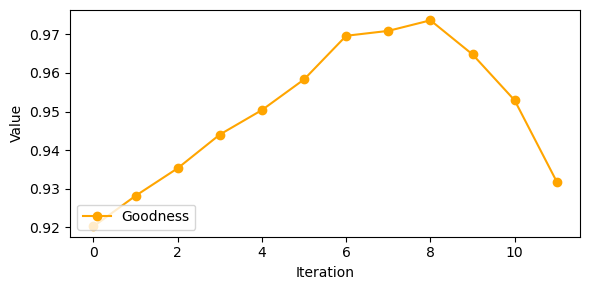

In [19]:
iterations = np.arange(len(r_squared_values))

plt.figure(figsize=(6, 3))
plt.plot(iterations, goodness_metrics, label='Goodness', marker='o', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend(loc='lower left')
plt.grid(False)
plt.tight_layout()
plt.show()


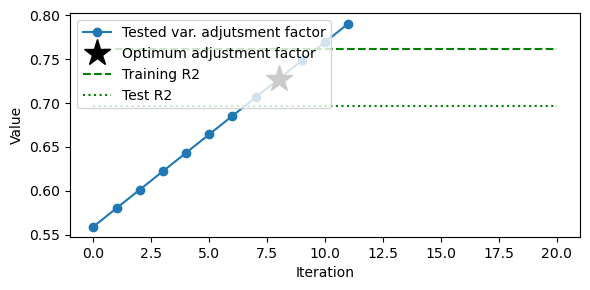

In [20]:
iterations = np.arange(len(r_squared_values))

plt.figure(figsize=(6, 3))
plt.plot(iterations, tested_r_squared, label='Tested var. adjutsment factor', marker='o')
plt.plot(iterations[max_idx], best_r_squared, label='Optimum adjustment factor', marker='*', markersize=20, color='black', linewidth=0.001)

plt.hlines(y=r2_train_avg, xmin=0.0, xmax=20, linestyle='--', color='green', label='Training R2')
plt.hlines(y=r2_test_avg, xmin=0.0, xmax=20, linestyle=':', color='green', label='Test R2')
# plt.hlines(y=best_r_squared, xmin=0.0, xmax=17.5)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


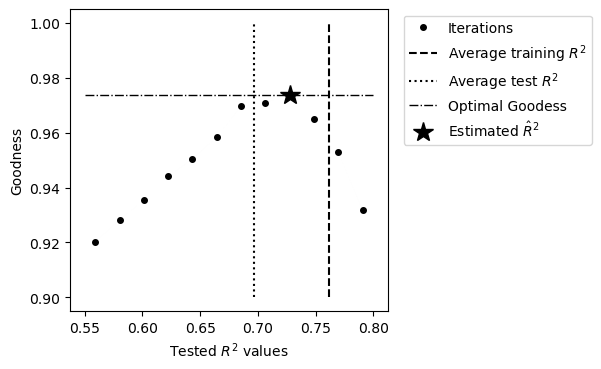

In [22]:
plt.figure(figsize=(6.2, 3.8))
plt.plot(tested_r_squared, goodness_metrics, marker='o', markersize=4, linewidth=0.001, color='black', label='Iterations')
plt.vlines(x=r2_train_avg, ymin=0.90, ymax=1.00, linestyle='--', color='black', label='Average training $R^2$')
plt.vlines(x=r2_test_avg, ymin=0.90, ymax=1.00, linestyle=':', color='black', label='Average test $R^2$')
plt.vlines(x=best_r_squared, ymin=0.92, ymax=0.99, linestyle='-', color='black', linewidth=0.001)
plt.hlines(y=best_goodness, xmin=0.55, xmax=0.80, linestyle='-.', color='black', linewidth=1, label='Optimal Goodess')

plt.plot(best_r_squared, goodness_metrics[max_idx], marker='*', markersize=15, color='black', linewidth=0.001, label="Estimated $\hatR^2$")
# plt.axvspan(r2_kfolds_min, r2_kfolds_max, color='gray', alpha=0.3, label='range')

plt.xlabel('Tested $R^2$ values')
plt.ylabel('Goodness')
plt.legend(loc=(1.05, 0.55), facecolor='white')

plt.grid(False)
plt.tight_layout()
plt.show()

# ACCURACY plots

In [29]:
r2_kfolds_max

0.7907

In [30]:
# Create SGB model instance
model_ml = ConditionalML(regressor=GradientBoostingRegressor,
                         r_squared=best_r_squared,
                         reg_hyperparams={'alpha': 0.9,
                                         'ccp_alpha': 0.0,
                                         'criterion': 'friedman_mse',
                                         'init': None,
                                         'learning_rate': 0.05,
                                         'loss': 'squared_error',
                                         'max_depth': 2,
                                         'max_features': None,
                                         'max_leaf_nodes': None,
                                         'min_impurity_decrease': 0.0,
                                         'min_samples_leaf': 4,
                                         'min_samples_split': 4,
                                         'min_weight_fraction_leaf': 0.0,
                                         'n_estimators': 100,
                                         'n_iter_no_change': None,
                                         'random_state': 42,
                                         'subsample': 0.8,
                                         'tol': 0.0001,
                                         'validation_fraction': 0.1,
                                         'verbose': 0,
                                         'warm_start': False}
)

model_ml.fit(model_set[['NS_var1']].values, model_set['NS_var2'].values)

# Predicting training data
_, _, quantiles_ml, _, _ = model_ml.predict(valid_set[['NS_var1']].values, return_pdf=True)

In [31]:
# Inverse transform per quantile
# quantiles_ml_or = np.array([nscorer_tg.inverse_transform(quantile) for quantile in quantiles_ml])


Accuracy plot for ML distributions


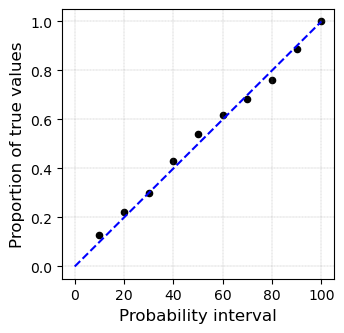

In [32]:
print('\nAccuracy plot for ML distributions')
acc_ml = AccuracyEvaluator(quantile_levels, quantiles_ml, valid_set['NS_var2'].values)
acc_ml.accuracy_plot(num_intervals=10, figsize=(3.5,3.5), show_results=False, leg_visible=False)
acc_ml_metrics = acc_ml.get_results()